In [1]:
import os
from pathlib import Path
import sys

import cmocean
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import savemat
from scipy.fft import fft, fftshift
from scipy.signal import spectrogram

sys.path.insert(0, "/Users/williamjenkins/Research/Projects/BOGP/Source/BOGP")
from figures import plot_ambiguity_surface
from tritonoa.io import read_ssp
from tritonoa.kraken import run_kraken
from tritonoa.sp import beamformer

In [2]:
DATADIR = Path("/Users/williamjenkins/Research/Projects/BOGP/Data/SWELLEX96/VLA/selected")
# contents = np.load(DATADIR / "merged.npz")
# x = contents["X"]
# # t = contents["t"]
# print(x.shape)

In [3]:
freq = 201
p = np.load(DATADIR / f"{freq}.0Hz/data.npy")
fs = 1500
M = p.shape[1]
NT = 350
# N_snap = x.shape[0] // NT
NFFT = 2 ** 15
fvec = (fs / NFFT) * np.arange(0, NFFT)

In [38]:
# def find_freq_bin(fvec, X, f0):
#     f_lower = f0 - 1
#     f_upper = f0 + 1
#     ind = (fvec >= f_lower) & (fvec < f_upper)
#     data = (np.abs(X).sum(axis=1) / M)
#     data[~ind] = -2009
#     return np.argmax(data)

# fvec = np.linspace(0, 1500 / 2 - 1 / NFFT, NFFT)
# fvec = (fs / NFFT) * np.arange(0, NFFT)

# # x[:, 42] = 0 # Remove corrupted channel
# x[:, 42] = x[:, [41,43]].mean(axis=1)

# p = np.zeros((NT, M), dtype=complex)
# for i in range(NT):
#     idx_start = i * N_snap
#     idx_end = (i + 1) * N_snap

#     X = fft(x[idx_start:idx_end], n=NFFT, axis=0)
#     # X = fftshift(X)
#     fbin = find_freq_bin(fvec, X, freq)
#     # print(fvec[fbin])
#     p[i] = X[fbin]

# print(p.shape)

In [39]:
# plt.plot(fvec, np.abs(X[:, 0]))
# plt.xlim([0, 400])
# plt.ylim([0, 2])

## Beamforming

In [12]:
c = 1500
l = c / freq
d = 1.875
q = np.arange(M, dtype=int) # Element index
# xq = np.expand_dims(((q - (M - 1) / 2) * d), 1)
xq = np.expand_dims(np.linspace(94.125, 212.25, 64), 1)

# Range of angle space
thetalim = [-50, 50]
theta_resolution = 0.1
# Angular search grid
theta = np.expand_dims(np.arange(thetalim[0], thetalim[1] + theta_resolution, theta_resolution), 1)

# Design (steering) matrix
sin_theta = np.sin(theta * (np.pi / 180))
sensing_matrix = np.exp(-1j * 2 * np.pi / l * xq * sin_theta.conj().T) / np.sqrt(M)


In [14]:
sp = np.zeros((NT, len(theta)), dtype=complex)
for i in range(NT):
# i = 12
    d = np.expand_dims(p[i], 1)
    d /= np.linalg.norm(d)
    K = d.dot(d.conj().T)

    for j in range(len(theta)):
        w = np.expand_dims(sensing_matrix[:, j], 1)
        sp[i, j] = w.conj().T.dot(K).dot(w) / (w.conj().T.dot(w))

Text(0.5, 1.0, '201 Hz')

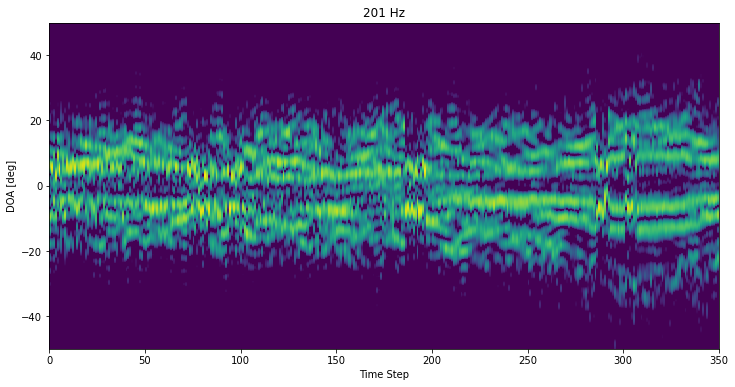

In [16]:
fig = plt.figure(figsize=(12, 6), facecolor="w")

surf = 10 * np.log10(np.abs(sp) / np.abs(sp).max())
plt.imshow(
    surf.T,
    aspect="auto",
    vmin=-20,
    vmax=0,
    cmap="viridis",
    extent=[0, 350, thetalim[0], thetalim[1]],
    interpolation="none",
    origin="lower"
)
plt.xlabel("Time Step")
plt.ylabel("DOA [deg]")
plt.title(f"{freq} Hz")

In [374]:
savemat(DATADIR / f"{freq}Hz_data.mat", {"f": freq, "p": p})

## MFP

### Single-Frequency

In [4]:



CBAR_KWARGS = {"location": "right", "pad": 0, "shrink": 1.0}

freq = 232
zvec = np.linspace(0, 200, 41)
rvec = np.linspace(1e-3, 10 + 1e-3, 101)

ranges = pd.read_csv(DATADIR / "gps_range.csv")["Range [km]"].values

for t in range(230, 350):
    loadpath = DATADIR / f"{freq:.1f}Hz" / f"ambsurf_t={t + 1:03d}.npy"
    savepath = loadpath.parent / "figures"
    os.makedirs(savepath, exist_ok=True)
    
    surf = np.load(loadpath)
    B = np.abs(surf) / np.max(np.abs(surf))
    B = 10 * np.log10(B)
    
    fig = plt.figure(figsize=(8, 6), facecolor="w", dpi=200)
    ax, im = plot_ambiguity_surface(B, rvec, zvec, cmap="cmo.thermal", interpolation=)
    ax.axvline(ranges[t], color="r")
    cbar = plt.colorbar(im, ax=ax, **CBAR_KWARGS)
    cbar.set_label("Normalized Correlation [dB]")
    ax.set_xlabel("Range [km]")
    ax.set_ylabel("Depth [m]")
    ax.set_title(f"Time Step = {t + 1:03d}, GPS Range = {ranges[t]:.2f} km")
    break
    fig.savefig(savepath / f"ambsurf_t={t + 1:03d}.png")
    plt.close()
 

In [22]:
freqs = [148, 166, 201, 235, 283, 338, 388]
zvec = np.linspace(1, 200, 100)
rvec = np.linspace(1e-3, 10, 500)


for t in range(350):
    surfs = np.zeros((len(freqs), len(zvec), len(rvec)))
    savepath = DATADIR / "multifreq" / "".join([f"{f}-" for f in freqs])[:-1]
    os.makedirs(savepath, exist_ok=True)
    try:
        for ff, f in enumerate(freqs):
            loadpath = DATADIR / f"{f:.1f}Hz" / f"ambsurf_t={t + 1:03d}.npy"
            surf = np.load(loadpath)
            # surf = np.abs(surf) / np.max(np.abs(surf))
            # surf = 10 *  np.log10(surf)
            surfs[ff] = surf

            # fig = plt.figure(figsize=(12, 9), facecolor="w", dpi=200)
            # ax, im = plot_ambiguity_surface(surf, rvec, zvec)
            # cbar = plt.colorbar(im, ax=ax, **CBAR_KWARGS)
            # cbar.set_label("Normalized Correlation [dB]")
            # ax.set_xlabel("Range [km]")
            # ax.set_ylabel("Depth [m]")
            # ax.set_title(f"{f} Hz: Time Step = {t + 1:03d}")
            # plt.show()
            
        # B = np.sum(surfs, axis=0)
        # B -= B.max()
        # B /= np.max(B)
        # B = 10 * np.log10(B)
        B = np.mean(surfs, axis=0)
        np.save(savepath / f"ambsurf_mf_t={t + 1:03d}.npy", B)

        # fig = plt.figure(figsize=(8, 6), facecolor="w", dpi=200)
        # # ax, im = plot_ambiguity_surface(B, rvec, zvec, cmap="cmo.thermal", vmin=-20)
        # ax, im = plot_ambiguity_surface(B, rvec, zvec, cmap="cmo.thermal", vmin=0, vmax=1)
        # ax.axvline(ranges[t], color="r")
        # cbar = plt.colorbar(im, ax=ax, **CBAR_KWARGS)
        # cbar.set_label("Centered Average Correlation [dB re max(B)]")
        # ax.set_xlabel("Range [km]")
        # ax.set_ylabel("Depth [m]")
        # ax.set_title(f"Multi-Freq {freqs} Hz: Time Step = {t + 1:03d}, GPS Range = {ranges[t]:.2f} km")
        # fig.savefig(savepath / f"ambsurf_t={t + 1:03d}.png")
        # plt.close()
    
    except FileNotFoundError:
        pass


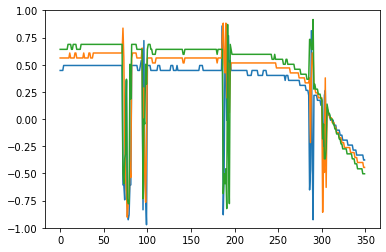

In [99]:
freqs = [283, 338, 388]


for f in freqs:
    f_hist = np.load(f"/Users/williamjenkins/Research/Projects/BOGP/Data/SWELLEX96/VLA/selected/{f}.0Hz/f_hist.npy")
    plt.plot(f_hist - f)
    plt.ylim(-1, +1)

In [101]:
def speed_in_los(fo, fs, unit="m/s"):
    c = 1500
    vs = c * (fs / fo - 1)
    if unit == "m/s":
        return vs
    elif unit == "kt":
        vs = vs * 3600 / 1852
        return vs

In [104]:
speed_in_los(232, 232.35, unit="kt")
2 ** 11

2048

## Spectrogram

In [6]:
data = np.load(DATADIR / "merged.npz")
x = data["X"]
t = data["t"]

In [7]:
inds = np.where((t > 2400) & (t < 3600))

In [ ]:
channel = -1

f, t, Sxx = spectrogram(x[:,channel], fs=1500, nfft=2**14, noverlap=0)
Sxx = 10 * np.log10(Sxx / Sxx.max())

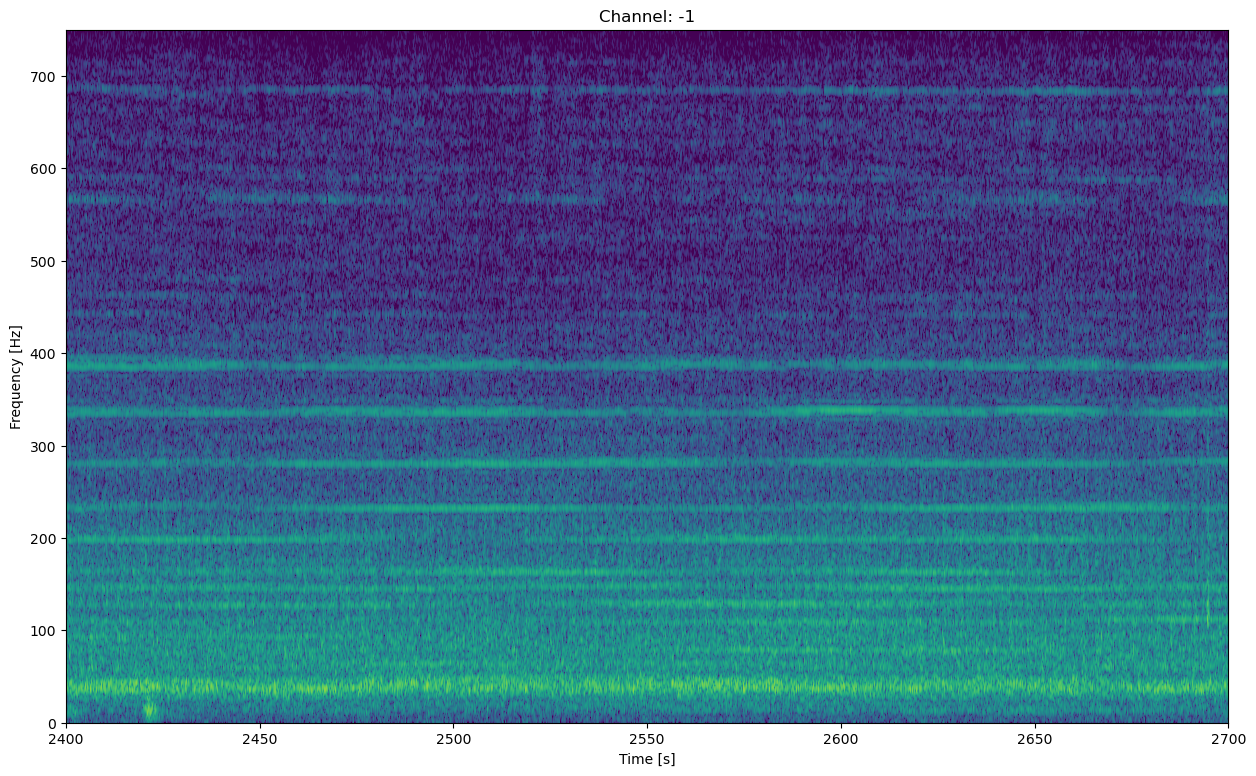

In [10]:
fig = plt.figure(figsize=(15, 9))
plt.imshow(Sxx, aspect="auto", origin="lower", vmin=-50, vmax=0, extent=[min(t), max(t), min(f), max(f)])
# plt.ylim([200, 400])
plt.xlim([2400, 2700])
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title(f"Channel: {channel}")
plt.show()

# Troubleshooting

In [23]:
K1 = np.load("/Users/williamjenkins/Research/Projects/BOGP/Data/localization/experimental/serial_test_surf4/timestep=249/data/measurement_covariance.npy")

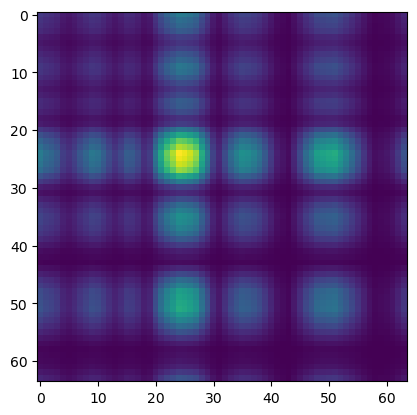

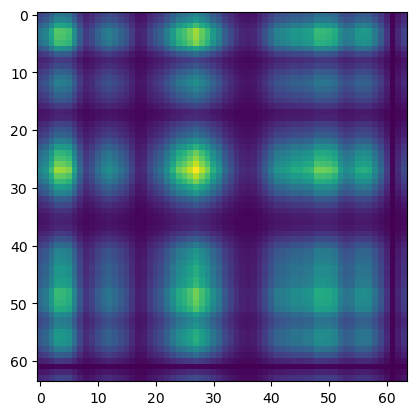

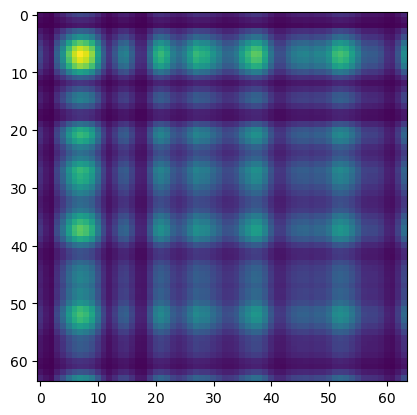

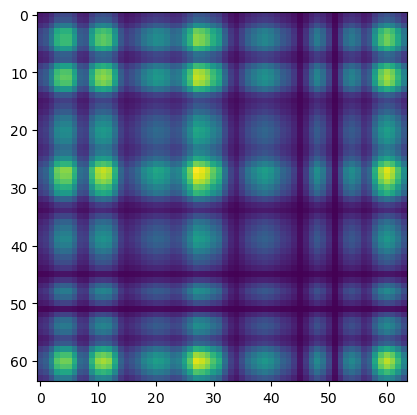

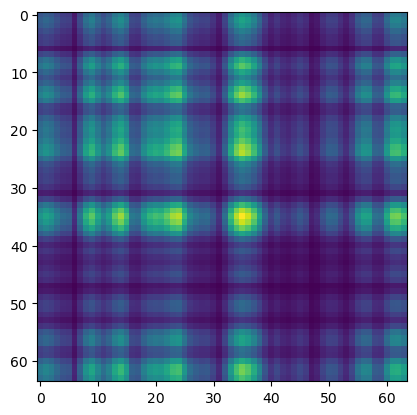

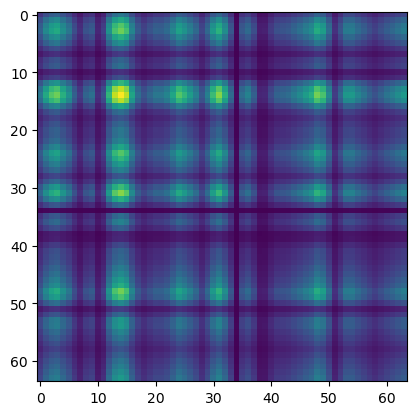

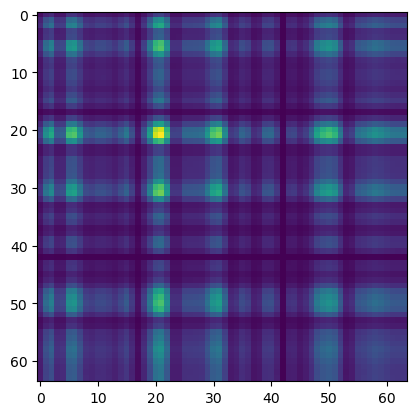

In [20]:
# np.save(Path.cwd() / "b4_surf.npy", B)
# B = np.load(Path.cwd() / "b4_surf.npy")
for f in range(7):
    plt.imshow(abs(K1[f]))
    plt.show()

In [24]:
from objective import objective_function as obj
import swellex

zvec = np.linspace(1, 200, 50)
rvec = np.linspace(10e-3, 10, 50)
B = np.zeros((len(zvec), len(rvec)))

for zz, z in enumerate(zvec):
    for rr, r in enumerate(rvec):
        B[zz, rr] = obj(
            {
                "env_parameters": swellex.environment,
                "tilt": -1,
                "K": K1,
                "frequencies": [148, 166, 201, 235, 283, 338, 388],
                "src_z": z,
                "rec_r": r,
            }
        )["bartlett"][0]

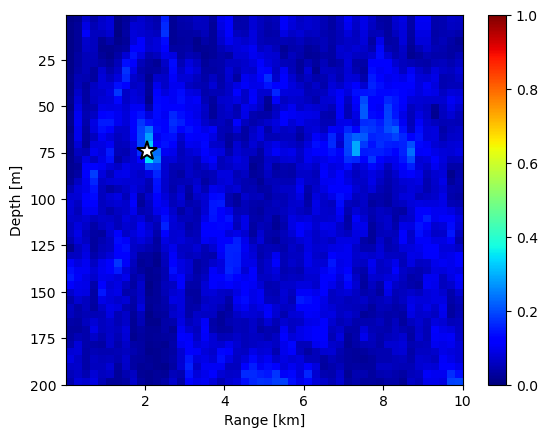

0.39202642879695054

In [25]:
import cmocean


ax, im = plot_ambiguity_surface(B, rvec, zvec, vmin=0, vmax=1)
ax.set_xlabel("Range [km]")
ax.set_ylabel("Depth [m]")
plt.colorbar(im)
plt.show()

B.max()
